In [30]:
from scipy.spatial import kdtree
from tqdm import tqdm
import torch
from albumentations.pytorch import ToTensorV2
from albumentations import ToFloat
import io
from pathlib import Path
from PIL import Image
import bisect
from math import pi
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from sklearn.cluster import DBSCAN
import requests
import datetime
import os
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from metavision_core.event_io import EventsIterator
from metavision_sdk_core import RoiFilterAlgorithm, FlipXAlgorithm
from metavision_sdk_cv import (
    RotateEventsAlgorithm,
    SpatioTemporalContrastAlgorithm,
    SparseOpticalFlowAlgorithm,
    SparseOpticalFlowConfigPreset,
    AntiFlickerAlgorithm,
)
from metavision_sdk_core import OnDemandFrameGenerationAlgorithm as FrameGen
import scipy.ndimage
import re
import sys
import cv2
from glob import glob
from hyperscope import config
from itertools import chain
from unet.model import UNetLightning as UNet
from collections import defaultdict


from scipy.optimize import linear_sum_assignment


class PointTracker:
    def __init__(self, max_age, min_hits, max_dist):
        self.max_age = max_age
        self.min_hits = min_hits
        self.max_dist = max_dist
        self.trackers = []
        self.frame_count = 0
        self.id = self._id_gen()

    def _id_gen(self):
        id = -1
        while True:
            id += 1
            yield id

    def update(self, points, categories):
        self.frame_count += 1  # Fixed typo

        # Update existing trackers
        if len(self.trackers) > 0:
            distances = self.calculate_distances(points)

            # Use the Hungarian algorithm to find the best matches
            row, col = linear_sum_assignment(distances)

            # Update matched trackers and create new ones for unmatched points
            matched_trackers = set()  # Changed from 'matched' to 'matched_trackers'
            for tracker_idx, point_idx in zip(row, col):
                if distances[tracker_idx, point_idx] <= self.max_dist:
                    category = categories[point_idx]
                    # update the trackers position, age, and update delta
                    self.trackers[tracker_idx]["position"] = points[point_idx]
                    self.trackers[tracker_idx]["age"] += 1
                    self.trackers[tracker_idx]["time_since_update"] = 0  # Reset update delta
                    if (
                        self.trackers[tracker_idx]["category"] == 0
                        and self.trackers[tracker_idx]["age"] >= self.min_hits
                    ):
                        self.trackers[tracker_idx]["category"] = np.argmax(
                            np.bincount([c for c in self.trackers[tracker_idx]["categories"] if c > 0])
                        )
                    elif self.trackers[tracker_idx]["category"] == 0:
                        self.trackers[tracker_idx]["categories"].append(category)
                    matched_trackers.add(tracker_idx)
                else:
                    self.create_new_tracker(points[point_idx])

            # Create new trackers for unmatched points
            for i in range(len(points)):
                if i not in col:
                    self.create_new_tracker(points[i])

            # remove old trackers
            self.trackers = [
                t
                for i, t in enumerate(self.trackers)
                if i in matched_trackers or t["time_since_update"] < self.max_age
            ]
        else:
            # create new trackers for each point if no trackers exist yet
            for point in points:
                self.create_new_tracker(point)

        for t in self.trackers:
            t["time_since_update"] += 1

        return self.objects

    def calculate_distances(self, points):
        """
        Generate a 2D array of shape [trackers, points] with distances
        """
        # create np array for positions
        positions = np.array([t["position"] for t in self.trackers])
        # Calculate the differences
        diffs = positions[:, np.newaxis] - points
        # Return the euclidean distances
        return np.sqrt((diffs**2).sum(axis=2))

    def create_new_tracker(self, point):
        self.trackers.append(
            {
                "id": next(self.id),
                "position": point,
                "category": 0,
                "age": 1,
                "time_since_update": 0,
                "categories": [],
            }
        )

    @property
    def objects(self):
        return [
            (t["id"], t["position"][0], t["position"][1], self.frame_count, t["category"])
            for t in self.trackers
            if t["age"] >= self.min_hits
        ]


class ResultTree:
    def __init__(self, *args, **kwargs):
        self.points = []
        self.tree = None
        self._args = args
        self._kwargs = kwargs

    def add_points(self, results):
        # wrap the results in a list if it is not already a list
        if results is not list:
            results = [results]
        for result in results:
            self.points.extend(result.patches)

    def add_points_and_update(self, result):
        self.add_points(result)
        self.update()

    def update(self):
        self._build(recreate=True)

    def _build(self, recreate=False):
        if len(self.points) == 0:
            raise ValueError("No results to build tree from")
        if self.tree is not None and not recreate:
            return  # tree already built
        # build a spatial and spatio-temporal tree
        self.tree = kdtree.KDTree([p.as_point() for p in self.points], *self._args, **self._kwargs)
        self.spatial_tree = kdtree.KDTree(
            [p.as_point()[:2] for p in self.points], *self._args, **self._kwargs
        )

    def get_tree(self, point):
        if len(point == 2):
            return self.spatial_tree
        return self.tree

    def query(self, *args, **kwargs):
        self._build()  # build the tree if it has not been built
        tree = self.get_tree(args[0])
        idx, dist = tree.query(*args, **kwargs)
        return self.points[idx].result, dist

    def query_ball_point(self, *args, **kwargs):
        self._build()  # Build the tree if it has not been built
        # check if the t value is positive
        tree = self.get_tree(args[0])
        idxs = tree.query_ball_point(*args, **kwargs)
        found_results = set()  # Use a set to avoid duplicate results
        for idx in idxs:
            found_results.add(self.points[idx].result)  # Return parent Result for each point
        return found_results


class Patch:
    def __init__(self, coords, patch_size, np_patch):
        self.coords = coords
        self.patch_size = patch_size
        self.np_patch = np_patch
        self.torch_patch = None
        self.categories = []
        self._result = None
        self._t = -1

    def __getattr__(self, name):
        try:
            # check if the attribute is in the class
            super().__getattribute__(name)
        except AttributeError:
            return getattr(self.np_patch, name)

    @property
    def t(self):
        if self._t < 0:
            raise ValueError("Timestamp has not been set")
        return self._t

    @t.setter
    def t(self, value):
        if value < 0:
            raise ValueError("Timestamp must be positive")
        self._t = value

    @property
    def centroid(self):
        non_zero = np.nonzero(self.np_patch)
        if len(non_zero) == 0:
            return (
                self.patch_size // 2,
                self.patch_size // 2,
            )  # Return the center of the patch if there are no non-zero pixels
        x = np.mean(non_zero[1]) + self.coords[2]
        y = np.mean(non_zero[0]) + self.coords[0]
        return (x, y)

    @property
    def relative_centroid(self):
        centroid = self.centroid
        if centroid == (self.patch_size // 2, self.patch_size // 2):
            return centroid

        x = centroid[0] - self.coords[2]
        y = centroid[1] - self.coords[0]

        return (x, y)

    @property
    def x(self):
        return self.centroid[0]

    @property
    def y(self):
        return self.centroid[1]

    @property
    def rel_x(self):
        return self.relative_centroid[0]

    @property
    def rel_y(self):
        return self.relative_centroid[1]

    @property
    def category(self):
        if len(self.categories) == 0:
            return 0
        weights = np.array([0, 1.5, 1])
        return np.argmax(np.multiply(weights, ensure_min_length(self.categories)))

    def as_point(self):
        return (self.centroid[0], self.centroid[1], self.t)


def ensure_min_length(arr, min_length=3):
    padding = max(0, min_length - len(arr))
    return np.pad(arr, (0, padding), mode="constant")


class Result:
    def __init__(self, patches, img_path, ts):
        self.img_path = img_path
        self.patches = patches
        self.shape = (0, 0)
        self.ts = ts
        self.grouped_patches = self.group_patches()

        for patch in patches:
            patch.result = self

        with Image.open(img_path) as img:
            self.shape = (img.size[1], img.size[0])

    def __len__(self):
        return len(self.patches)

    @property
    def empty(self):
        len(self) == 0

    @property
    def patch_size(self):
        if self.empty:
            return 0
        return self.patches[0].patch_size

    def group_patches(self):
        # Step 1: Group patches by proximity
        points = np.array([patch.centroid for patch in self.patches])
        clustering = DBSCAN(eps=self.patch_size * 2, min_samples=2).fit(points)

        # Step 2 & 3: Group by category within proximity groups and calculate average centroids
        grouped_patches = defaultdict(list)
        for cluster_id, patch in zip(clustering.labels_, self.patches):
            if cluster_id != -1:  # -1 is the noise label in DBSCAN
                grouped_patches[cluster_id].append(patch)

        # Step 4: Calculate centroids and determine categories for groups
        final_groups = []
        for group in grouped_patches.values():
            categories = {
                0: [],
                1: [],
                2: [],
            }
            for patch in group:
                categories[patch.category].append(patch)
            category_counts = np.array([len(category) for category in categories.values()])
            category = np.argmax(category_counts)
            patches = list(chain.from_iterable(categories.values()))
            if category != 0:  # Ignore uncategorized patches
                x = np.mean([p.x for p in patches])
                y = np.mean([p.y for p in patches])
                rel_x = np.mean([p.rel_x for p in patches])
                rel_y = np.mean([p.rel_y for p in patches])
                final_groups.append(
                    {
                        "centroid": (x, y),
                        "relative_centroid": (rel_x, rel_y),
                        "category": category,
                        "patches": patches,
                    }
                )

        return final_groups

    def get_grouped_centroids(self):
        return [
            (group["centroid"], group["relative_centroid"], group["category"])
            for group in self.grouped_patches
        ]

    def __array__(self, dtype=np.uint8):
        points = [np.array(patch).as_point() for patch in self.patches]
        return np.array(as_point).astype(dtype)

    def add_patch(self, patch):
        self.patches.append(patch)

    def load_image(self):
        return Image.open(self.img_path)

    def assemble_patches(self):
        if len(self.patches) == 0:
            return None
        patch_img = np.zeros(self.shape, dtype=np.uint8)
        for patch in self.patches:
            y1, y2, x1, x2 = patch.coords
            try:
                patch_img[y1:y2, x1:x2] = patch.np_patch
            except ValueError:
                real_shape = patch_img[y1:y2, x1:x2].shape
                if real_shape[0] < patch.patch_size:
                    y2 = y1 + real_shape[0]
                    patch.np_patch = patch.np_patch[: real_shape[0], :]
                if real_shape[1] < patch.patch_size:
                    x2 = x1 + real_shape[1]
                    patch.np_patch = patch.np_patch[:, : real_shape[1]]
                patch_img[y1:y2, x1:x2] = patch.np_patch
        return patch_img


def parse_filename(filename):
    # Extract the base date and time, tiff file number, and page number using regex
    pattern = r".*_(\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}\.\d{2})_(\d+)_page_(\d+)\.tif"
    match = re.match(pattern, filename)
    if not match:
        pattern = r".*_(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})(\d{2})_(\d+)\.tif"
        match = re.match(pattern, filename)
        if not match:
            raise ValueError(f"Filename {filename} does not match the expected pattern")
        base_datetime_str = f"{match.group(1)}-{match.group(2)}-{match.group(3)}T{match.group(4)}-{match.group(5)}-{match.group(6)}{format((int(match.group(7))/1e6), '.3f').lstrip('0').rstrip('0')}"
        # Set the tiff file number and page number such that the timestamp is the same as the base date-time string
        tiff_file_number = 1
        page_number = 0

    else:
        base_datetime_str = match.group(1)
        tiff_file_number = int(match.group(2))
        page_number = int(match.group(3))

    # Convert base date-time string to datetime object
    base_datetime = datetime.datetime.strptime(base_datetime_str, "%Y-%m-%dT%H-%M-%S.%f")

    # Calculate total milliseconds to add
    total_pages_before = (tiff_file_number - 1) * 345
    total_page_number = total_pages_before + page_number
    total_milliseconds = total_page_number * 30  # 30ms per page

    # Add milliseconds to base datetime
    final_datetime = base_datetime + datetime.timedelta(milliseconds=total_milliseconds)

    return final_datetime


def block_view(A, block_shape):
    shape = (A.shape[0] // block_shape[0], A.shape[1] // block_shape[1]) + block_shape
    strides = (block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides
    return np.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)


def calculate_snr(image, patch_size):
    blocks = block_view(image, (patch_size, patch_size))
    flattened_blocks = blocks.reshape(-1, patch_size, patch_size)
    means = np.mean(flattened_blocks, axis=(1, 2))
    stds = np.std(flattened_blocks, axis=(1, 2)) + 1e-5  # Avoid division by zero
    snr_values = means / stds
    snr_map = snr_values.reshape(blocks.shape[0], blocks.shape[1])
    return snr_map


def calculate_std_map(image, patch_size):
    blocks = block_view(image, (patch_size, patch_size))
    flattened_blocks = blocks.reshape(-1, 16, 16)
    stds = np.std(flattened_blocks, axis=(1, 2)) + 1e-5  # Avoid division by zero
    std_map = stds.reshape(blocks.shape[0], blocks.shape[1])
    return std_map


def smooth_snr_map(snr_map, kernel_size):
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
    smoothed_snr_map = scipy.ndimage.convolve(snr_map, kernel, mode="constant", cval=0.0)
    return smoothed_snr_map.astype(np.float32)


def gen_mask(image, threshold):
    mask = np.zeros_like(image, dtype=np.float32)
    mask[image > threshold] = 1
    return mask


def expand_mask(mask, patch_size):
    expanded_mask = np.kron(mask, np.ones((patch_size, patch_size), dtype=np.uint8))
    return expanded_mask


def process_image(image, patch_size=16):
    image = Image.open(image)
    try:
        image = np.array(image)
    except:
        print(f"Could not process image {image}")
        return None, None, None
    dtype = image.dtype
    dtype_max = np.iinfo(dtype).max  # Get the maximum value for the image dtype

    # Normalize the image
    normed = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)

    snr_img = smooth_snr_map(calculate_snr(normed, patch_size), 5)  # Calculate the SNR map
    mean, std = np.mean(snr_img), np.std(snr_img)
    if std < 0.06 and not np.isclose(std, 0.06, atol=0.01):
        return None, None, None

    mask = gen_mask(snr_img, mean + 4 * std)  # Generate the mask

    if np.sum(mask) < mask.size * 0.001:
        return None, None, None  # If the mask is empty, return None

    mask = expand_mask(mask, patch_size)  # Expand the mask to the original image size

    # Pad the mask if necessary to match the image size
    pad_height = (image.shape[0] - mask.shape[0] % image.shape[0]) % image.shape[0]
    pad_width = (image.shape[1] - mask.shape[1] % image.shape[1]) % image.shape[1]
    mask = np.pad(mask, ((0, pad_height), (0, pad_width)), mode="constant", constant_values=0)

    # Apply the mask to the image
    normed = normed * mask
    denormed = (normed * dtype_max).astype(dtype)
    # Normalize the image to the full dtype range
    # clip the mas
    return normed, denormed, mask


# Add UNET model to the path
model = UNet()
model_path = config.MODELS_DIR / "unet-UN-348-epoch=05-val_dice=0.89.ckpt"
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.eval()

rcParams.update({"figure.autolayout": True})


def pixel_to_micron(pix, pitch, magnification):
    return pix * pitch / magnification


def micron_to_pixel(microns, pitch, magnification):
    return microns * magnification / pitch


def map_cmos_to_ebis(cmos, input_unit="microns", output_unit="pixel"):
    magnification_cmos = 38  # CMOS magnification
    magnification_ebis = 38  # EBIS magnification
    cmos_pitch = 3.45  # CMOS pitch in meters (micron/pixel)
    ebis_pitch = 15  # EBIS pitch in meters (micron/pixel)

    micron_units = ["microns", "micron", "um"]
    pixel_units = ["pixels", "pixel", "px"]

    # Convert CMOS units to microns if input is in pixels
    if input_unit in pixel_units:
        cmos = pixel_to_micron(cmos, cmos_pitch, magnification_cmos)

    # Convert to EBIS space (either pixels or microns)
    if output_unit in pixel_units:
        return micron_to_pixel(cmos, ebis_pitch, magnification_ebis)  # Convert to EBIS pixels
    elif output_unit in micron_units:
        return cmos  # Already in microns, no further conversion needed

    raise ValueError(f"Invalid unit: {input_unit} or {output_unit}")


def map_ebis_to_cmos(ebis, input_unit="microns", output_unit="pixel"):
    magnification_cmos = 38  # CMOS magnification
    magnification_ebis = 38  # EBIS magnification
    cmos_pitch = 3.45  # CMOS pitch in meters (micron/pixel)
    ebis_pitch = 15  # EBIS pitch in meters (micron/pixel)

    micron_units = ["microns", "micron", "um"]
    pixel_units = ["pixels", "pixel", "px"]

    # Convert CMOS units to microns if input is in pixels
    if input_unit in pixel_units:
        ebis = pixel_to_micron(ebis, ebis_pitch, magnification_ebis)

    # Convert to EBIS space (either pixels or microns)
    if output_unit in pixel_units:
        return micron_to_pixel(ebis, cmos_pitch, magnification_cmos)  # Convert to EBIS pixels
    elif output_unit in micron_units:
        return ebis  # Already in microns, no further conversion needed

    raise ValueError(f"Invalid unit: {input_unit} or {output_unit}")


def split_img(img, mask, patch_size, threshold=0.2):
    """
    Process a single image/mask pair, cropping and splitting them into patches
    of the specified size. Patches with too few non-zero pixels are skipped.
    """

    # Get bounding box for non-zero region in the mask
    nz = np.nonzero(mask)
    if len(nz[0]) == 0:
        return
    min_y, max_y = np.min(nz[0]), np.max(nz[0])
    min_x, max_x = np.min(nz[1]), np.max(nz[1])
    top_left = (min_y, min_x)
    adjustments = {}
    # Crop to the smallest area that can encompass the full non-zero area
    crop_height = max_y - min_y + 1
    crop_width = max_x - min_x + 1

    # Adjust crop to be divisible by patch size
    crop_height = (crop_height + patch_size - 1) // patch_size * patch_size
    crop_width = (crop_width + patch_size - 1) // patch_size * patch_size

    # Ensure the crop fits within the original image/mask dimensions
    crop_height = min(crop_height, img.shape[0] - min_y)
    crop_width = min(crop_width, img.shape[1] - min_x)

    # Crop mask and image
    cropped_mask = mask[min_y : min_y + crop_height, min_x : min_x + crop_width]
    cropped_img = img[min_y : min_y + crop_height, min_x : min_x + crop_width]
    # Adjust crop if it is still not divisible by patch size
    if cropped_mask.shape[0] % patch_size != 0:
        cropped_mask = cropped_mask[: -(cropped_mask.shape[0] % patch_size), :]
        cropped_img = cropped_img[: -(cropped_img.shape[0] % patch_size), :]

    if cropped_mask.shape[1] % patch_size != 0:
        cropped_mask = cropped_mask[:, : -(cropped_mask.shape[1] % patch_size)]
        cropped_img = cropped_img[:, : -(cropped_img.shape[1] % patch_size)]
    # get the top left corner of the crop area in the original image
    # accounting fo
    # Split into patches
    mask_patches = [
        Patch(
            coords=(
                top_left[0] + y,
                top_left[0] + y + patch_size,
                top_left[1] + x,
                top_left[1] + x + patch_size,
            ),
            patch_size=patch_size,
            np_patch=cropped_mask[y : y + patch_size, x : x + patch_size],
        )
        for y in range(0, cropped_mask.shape[0], patch_size)
        for x in range(0, cropped_mask.shape[1], patch_size)
    ]

    img_patches = [
        Patch(
            coords=(
                top_left[0] + y,
                top_left[0] + y + patch_size,
                top_left[1] + x,
                top_left[1] + x + patch_size,
            ),
            patch_size=patch_size,
            np_patch=cropped_img[y : y + patch_size, x : x + patch_size],
        )
        for y in range(0, cropped_img.shape[0], patch_size)
        for x in range(0, cropped_img.shape[1], patch_size)
    ]

    # Save patches
    for mask_patch, img_patch in zip(mask_patches, img_patches):
        # Skip patches with too few non-zero pixels
        if np.count_nonzero(mask_patch.np_patch) < threshold * patch_size**2:
            yield (None, None)
        yield (mask_patch, img_patch)


# Helper function to send an image to the segmentation model


def send_image_for_segmentation(image_path, ts, patch_size=128):
    image_path = Path(image_path)
    _, img, mask = process_image(image_path, patch_size=8)
    if img is None:
        return None
    img = np.array(img)
    patches = []

    # Collect patches
    for _, patch in split_img(img, mask, patch_size):
        if patch is None:
            continue
        patch.torch_patch = ToFloat()(image=np.array(patch.np_patch))["image"]
        patch.torch_patch = ToTensorV2()(image=patch.torch_patch)["image"]
        patches.append(patch)

    # Run the patches through the model
    if len(patches) == 0:
        return None
    segments = torch.stack([p.torch_patch for p in patches])
    with torch.no_grad():
        output = model(segments)
        output = torch.argmax(output, dim=1)
        output = output.cpu().numpy()
    output = output.reshape(-1, patch_size, patch_size).astype(np.uint8)
    assert len(output) == len(patches), "Output length does not match patches length"

    # Use a dictionary to store unique outputs
    unique_outputs = {}

    for patch, out in zip(patches, output):
        out_key = out.tobytes()  # Convert array to bytes for hashing
        if out_key not in unique_outputs:
            unique_outputs[out_key] = patch
        else:
            # If we find a duplicate, remove both the original and the duplicate
            unique_outputs.pop(out_key, None)

    # Process only the unique patches
    unique_patches = []
    for out_key, patch in unique_outputs.items():
        patch.np_patch = np.frombuffer(out_key, dtype=np.uint8).reshape(patch_size, patch_size)
        patch.torch_patch = None
        patch.categories = np.bincount(patch.np_patch[patch.np_patch > 0].flatten())
        patch.t = ts
        unique_patches.append(patch)

    result = Result(unique_patches, image_path, ts)
    yield result


def gen_ts_img_map(img_dir):
    ts_img_map = {}
    print("Mapping image timestamps to image paths...")
    cmos_images = os.listdir(img_dir)
    for img in cmos_images:
        try:
            ts = parse_filename(img).timestamp()  # Convert to microseconds
            if ts >= datetime.datetime(2024, 7, 30, 13, 51, 19).timestamp():
                ts_img_map[ts] = img
        except ValueError:
            print(f"Skipping {img}")
            continue  # Skip files that do not match the expected pattern
    # Sort the map by timestamp
    ts_img_map = dict(sorted(ts_img_map.items()))
    return ts_img_map


img_dir = config.INTERIM_DATA_DIR / "capillary" / "imgs"
ts_img_map = gen_ts_img_map(img_dir)
ts_img_map = dict(sorted(ts_img_map.items()))


def augment_flow(X, ext_events, start_date_timestamp):
    ext_trigger_ts = map(
        lambda x: datetime.timedelta(microseconds=x["t"].item()) + start_date_timestamp, ext_events
    )
    ext_trigger_ts = np.array([ts.timestamp() for ts in ext_trigger_ts])
    X_ts = map(lambda x: datetime.timedelta(microseconds=x["t"].item()) + start_date_timestamp, X)
    X_ts = np.array([ts.timestamp() for ts in X_ts])
    # Initialize an array to store the index of the nearest ext trigger event
    X_ext_trigger = np.zeros(X_ts.shape, dtype=np.int32)
    for i in range(len(X_ts)):
        idx = np.argmin(np.abs(X_ts[i] - ext_trigger_ts))
        X_ext_trigger[i] = ext_trigger_ts[idx]
    # Convert X_ext_trigger_idx to a structured array
    X_ext_trigger = np.array(list(zip(X_ext_trigger)), dtype=[("ext_trigger", np.int32)])
    new_dtype = X.dtype.descr + X_ext_trigger.dtype.descr
    X_with_ext_trigger_and_category = np.empty(X.shape, dtype=new_dtype)

    for name in X.dtype.names:
        X_with_ext_trigger_and_category[name] = X[name]
    X_with_ext_trigger_and_category["ext_trigger"] = X_ext_trigger["ext_trigger"]

    return X_with_ext_trigger_and_category

/tmp/ipykernel_3359/1738760047.py:500: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device("cpu"))


Mapping image timestamps to image paths...
Skipping image_20240730_133545_000127.tif
Skipping image_20240730_134621_000213.tif
Skipping image_20240730_134648_000209.tif
Skipping image_20240730_134923_999761.tif
Skipping image_20240730_134928_999753.tif
Skipping image_20240730_135001_999749.tif
Skipping image_20240730_135144_402260.npy
Skipping image_20240730_135150_000261.tif


In [46]:
img_dir = config.INTERIM_DATA_DIR / "capillary" / "imgs"
ts_img_map = gen_ts_img_map(img_dir)
ts_img_map = dict(sorted(ts_img_map.items()))

acc_time = 10  # Accumulation time in microseconds

# input_path = input('Enter the path to the file: ').strip()  # Path to the file
input_path = str(config.RAW_DATA_DIR / "metavision" / "recording_2024-07-30_13-51-19.raw")
width = 640
height = 480
processing_ts = 0
disable_stc = False
# File is named recording_date_time.raw e.g. recording_2024-07-16_13-39-21.raw
# Extract the starting date/time from the file name
filename = Path(input_path).stem
filename = "_".join(filename.split("_")[1:])
start_date_timestamp = datetime.datetime.strptime(filename, "%Y-%m-%d_%H-%M-%S")
accumulated_slices = []

print("Initializing filters...")


class ProcessingPipeline:
    algorithms = []
    bufs = [None]

    def __init__(self, *algorithms):
        for algorithm in algorithms:
            self.append(algorithm)

    def append(self, algorithm):
        self.algorithms.append(algorithm)
        self.bufs.insert(-1, algorithm.get_empty_output_buffer())

    def insert(self, i, algorithm):
        self.algorithms.insert(i, algorithm)
        if i >= len(self.bufs):
            i = -1  # keep None as the last item
        self.bufs.insert(i, algorithm.get_empty_output_buffer())

    def process_events(self, evts):
        current_buf = evts
        next_buf = self.bufs[0]

        for i, a in enumerate(self.algorithms):
            a.process_events(current_buf, next_buf)
            current_buf = next_buf
            next_buf = self.bufs[i + 1]

        return self.bufs[-2].numpy(copy=True)


def transform_roi_90deg_ccw(x0, y0, x1, y1, image_height):
    new_x0 = image_height - y1
    new_y0 = x0
    new_x1 = image_height - y0
    new_y1 = x1
    return new_x0, new_y0, new_x1, new_y1


height, width = 480, 640

x1, y1, x2, y2 = 265, 100, 430, 400
rot_algo = RotateEventsAlgorithm(height - 1, width - 1, -pi / 2)
stc_filter = SpatioTemporalContrastAlgorithm(width, height, 500, True)
roi_filter = RoiFilterAlgorithm(
    *transform_roi_90deg_ccw(x1, y1, x2, y2, height), output_relative_coordinates=True
)

x1, y1, x2, y2 = transform_roi_90deg_ccw(x1, y1, x2, y2, height)
width = x2 - x1
height = y2 - y1
flow_algo = SparseOpticalFlowAlgorithm(width, height, SparseOpticalFlowConfigPreset.FastObjects)
flip_x_algo = FlipXAlgorithm(width)
pipeline = ProcessingPipeline(
    stc_filter, rot_algo, roi_filter, flip_x_algo, flow_algo
)

start_ts = int((2.4e7 // acc_time) * acc_time)
print(f"Starting at {start_ts}")
mv_iterator = EventsIterator(
    input_path=input_path, delta_t=acc_time, start_ts=start_ts, max_duration=3e6
)

fga = FrameGen(width, height, 100)
time_accumulated = 0
ts = start_ts
disable_roi = False
ext_events = None
for evs in tqdm(mv_iterator, desc="Processing events"):
    processing_ts += mv_iterator.delta_t
    time_accumulated += mv_iterator.delta_t
    _ext_events = mv_iterator.get_ext_trigger_events()[::2]
    if ext_events is None:
        ext_events = _ext_events
    else:
        np.concatenate((ext_events, _ext_events))
    evts = pipeline.process_events(evs)
    if len(evs) > 0:
        accumulated_slices.append(evts)
if accumulated_slices:
    X = np.concatenate(accumulated_slices, axis=0)
else:
    X = np.empty((0, 3), dtype=np.float64)
del accumulated_slices  # Free up memory


print("Correlating events with ext trigger events...")
# Correlate the events in X with the ext trigger events by finding the nearest timestamp

X = augment_flow(X, ext_events, start_date_timestamp)


# # add an id to each event that is the hash of the x, y, t
X["id"] = np.array([hash((x, y, t)) for x, y, t in zip(X["x"], X["y"], X["t"])])


tree = ResultTree(leafsize=16)
for i, (ts, img) in enumerate(
    tqdm(ts_img_map.items(), desc="Segmenting images...", unit="images", total=len(ts_img_map))
):
    image_path = os.path.join(img_dir, img)
    for result in send_image_for_segmentation(image_path, ts, patch_size=64):
        if result is None:
            continue
        tree.add_points(result)
del ts_img_map  # Free up memory

Mapping image timestamps to image paths...
Skipping image_20240730_133545_000127.tif
Skipping image_20240730_134621_000213.tif
Skipping image_20240730_134648_000209.tif
Skipping image_20240730_134923_999761.tif
Skipping image_20240730_134928_999753.tif
Skipping image_20240730_135001_999749.tif
Skipping image_20240730_135144_402260.npy
Skipping image_20240730_135150_000261.tif
Initializing filters...
Starting at 24000000


Processing events: 300000it [00:21, 14224.28it/s]


Correlating events with ext trigger events...


Segmenting images...:   0%|          | 0/706 [00:00<?, ?images/s]

Could not process image <PIL.TiffImagePlugin.TiffImageFile image mode=I;16 size=1440x700 at 0x7F5EF61DEA40>


Segmenting images...:  35%|███▌      | 248/706 [01:15<02:18,  3.30images/s]


KeyboardInterrupt: 

In [45]:
from collections import defaultdict

uncategorized_points = defaultdict(
    list
)  # Key: event timestamp, Value: list of uncategorized points
categorized_points = defaultdict(list)  # Key: category, Value: list of categorized points

to_plot = []
for i, event in enumerate(
    tqdm(X, desc="Assigning categories to events", unit="events", total=len(X))
):
    max_dist = micron_to_pixel(5, 3.45, 38)
    center_x = int(map_ebis_to_cmos(event["center_x"], "pixel", "pixel"))
    center_y = int(map_ebis_to_cmos(event["center_y"], "pixel", "pixel"))
    query_point = np.array((center_x, center_y))
    results = tree.query_ball_point(query_point, r=max_dist, workers=-1, return_sorted=False)

    # Filter the ts to be within 10ms of the event timestamp
    results = list(filter(lambda x: abs(x.ts - event["ext_trigger"]) <= 10000, results))
    for result in results:
        points = result.get_grouped_centroids()
        for point in points:
            to_plot.append((event, point[1], point[2], result))


plot_points = {"points": [], "results": []}
for event, centroid, category, result in tqdm(to_plot, desc="updating pixel offsets"):
    offset_x = map_cmos_to_ebis(centroid[0], "pixel", "pixel")
    offset_y = map_cmos_to_ebis(centroid[1], "pixel", "pixel")
    x_micron = pixel_to_micron(event["center_x"] + offset_x, 15, 38)
    y_micron = pixel_to_micron(event["center_y"] + offset_y, 15, 38)
    _points = (x_micron, y_micron, event["t"], category)
    plot_points["points"].append(_points)
    plot_points["results"].append(result)

plot_points["points"] = np.array(
    plot_points["points"],
    dtype=[("x", np.uint32), ("y", np.uint32), ("t", np.float32), ("category", np.uint8)],
)
# sort points by time
points = plot_points["points"]
plot_points["points"] = points[points["t"].argsort()]
times = np.unique(points["t"])

tracker = PointTracker(5, 10, 10)

tracked_points = []
for t in tqdm(times, desc="tracking points"):
    mask = points["t"] == t
    x = points[mask]["x"]
    y = points[mask]["y"]
    xy = np.column_stack((x, y))
    categories = points[mask]["category"]

    new_tracked_points = tracker.update(xy, categories)
    new_tracked_points = [
        np.array(
            (p[0], p[1], p[2], t, p[4]),
            dtype=[("id", np.uint32), ("x", np.uint32), ("y", np.uint32), ("t", np.float32), ("category", np.uint8)],
        )
        for p in new_tracked_points
    ]

    tracked_points.extend(new_tracked_points)
tracked_points = np.array(tracked_points)
# Handle any remaining uncategorized points
# for ts, points in uncategorized_points.items():
#     nearest_categorized_ts = min(categorized_points.keys(), key=lambda x: abs(x - ts))
#     nearest_category = max(categorized_points[nearest_categorized_ts], key=lambda x: len(x))
#     for point in points:
#         point.category = nearest_category
#         categorized_points[nearest_category].append(point)

Assigning categories to events: 0events [00:00, ?events/s]
updating pixel offsets: 0it [00:00, ?it/s]
tracking points: 0it [00:00, ?it/s]


In [41]:
len(np.unique(tracked_points['id']))


6870

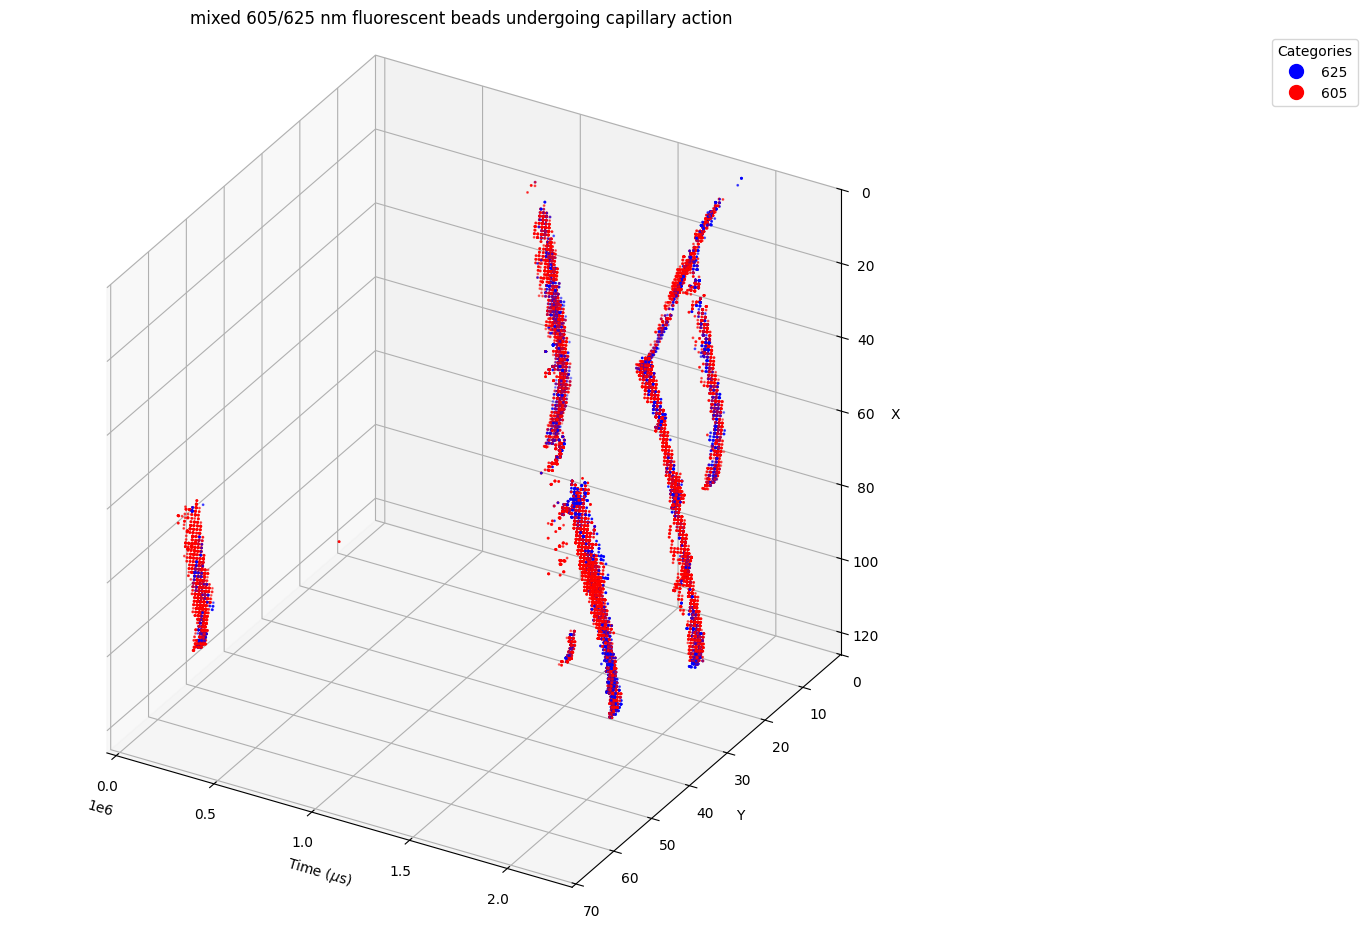

In [43]:
from scipy.spatial import kdtree
import numpy as np
from matplotlib.colors import Normalize







fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.set_ylabel('Y')
ax.set_xlabel(r'Time ($\mu$s)', rotation=90)
ax.set_zlabel('X')
ax.ticklabel_format(style='scientific', axis='x', scilimits=(0, 0))
ax.set_title('mixed 605/625 nm fluorescent beads undergoing capillary action')

# Function to map a category to a color (R, G, B format)
def get_color(category):
    category_colors = {
        2: [1, 0, 0],  # Red for 605 nm (R, G, B)
        1: [0, 0, 1],  # Blue for 625 nm (R, G, B)
        0: [0, 1, 0],    # Green for uncategorized (0 is uncategorized)
    }
    return category_colors.get(category, [0, 0, 0])  # Default to black if category not found
# convert plot_points to a structured array
points = tracked_points.copy()
# Normalize xyt
points['x'] -= points['x'].min()
points['y'] -= points['y'].min()
points['t'] -= points['t'].min()


points = points[::10]
colors = np.array([get_color(category) for category in points['category']])
# Create the 3D scatter plot
sc = ax.scatter3D(points['t'], points['y'], points['x'], c=colors, s=1)
categories = np.unique(points['category'])
category_labels = ['unlabeled', '625', '605']
# Set up the rest of your plot (legend, labels, etc.)
handles = [
    plt.Line2D([0], [0], marker='o', color=get_color(category), linestyle='', markersize=10, label=category_labels[category])
    for category in categories
]
ax.legend(handles=handles, title='Categories', loc='upper right', bbox_to_anchor=(1.5, 1))
max_x = points['x'].max()
max_y = points['y'].max()
tick_size = 10
ax.set_ylim(max_y + tick_size)
ax.set_zlim(max_x + tick_size)
ax.set_yticks(np.arange(0, max_y + tick_size, tick_size))
ax.set_zticks(np.arange(0, max_x + tick_size, tick_size * 2))
plt.tight_layout()
plt.margins(0, 0, 0)
ax.set_box_aspect([1, 1, 1])
ax.set_proj_type('ortho')
plt.show()

In [173]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg

outdir = config.PROCESSED_DATA_DIR / 'predictions'

color_map = (
    [255, 0, 0], [0, 255, 0]
)


plotted = set()

for i, res in enumerate(sorted(plot_points["results"], key=lambda x: x.ts)):
    if str(res.img_path) in plotted:
        continue
    plotted.add(str(res.img_path))
    
    diffractogram = np.array(res.load_image())
    img = res.assemble_patches()
    img_color = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    categories = [c[2] for c in res.get_grouped_centroids()]
    centroids = [np.array(c[0]) + np.array(c[1]) for c in res.get_grouped_centroids()]
    
    if len(categories) == 1:
        img_color[img != 0] = color_map[categories[0] - 1]
    elif len(centroids) == 1:
        category = np.argmax([p.category for p in res.patches])
        img_color[img != 0] = color_map[categories[0] - 1]
    else:
        mask = img != 0
        binary_image = mask.astype(np.uint8) * 255  # Convert to binary image
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        
        
            
        for c, cat in zip(centroids, categories):
            for contour in contours:
                contour_mask = np.zeros(img.shape, dtype=np.uint8)
                cv2.drawContours(contour_mask, [contour], 0, 1, -1)
                distance = cv2.pointPolygonTest(contour, c, True)
                if distance >= -64:
                    img_color[contour_mask == 1] = color_map[cat - 1]
                
    # Create a new figure
    dpi = 200
    height, width = img_color.shape[:2]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*width/dpi, height/dpi), dpi=dpi)

    # Display the diffractogram on the left
    ax1.imshow(diffractogram, cmap='gray')
    ax1.axis('off')

    # Display the color image on the right
    ax2.imshow(img_color)

    # Add scatter plot on the color image
    for c in centroids:
        ax2.scatter(c[0], c[1], color='white', edgecolors='black')

    ax2.axis('off')

    # Adjust layout
    plt.subplots_adjust(top=0.95, bottom=0.05, right=0.95, left=0.05, hspace=0, wspace=0.1)

    # Save the figure with a small border
    plt.savefig(outdir / f'{i}.png', dpi=dpi, bbox_inches='tight', pad_inches=0.05)

    # Close the figure to free up memory
    plt.close(fig)

In [8]:
color_map = (
    [255, 0, 0], [0, 255, 0]
)

original_points = plot_points["points"]
original_results = plot_points["results"]

# Create a list of tuples pairing each point with its result
paired_data = list(zip(original_points, original_results))

# Sort the paired data based on the 't' value of each point
sorted_data = sorted(paired_data, key=lambda x: x[0]['t'])  # x[0] is the point, x[0][2] is the 't' value

# Separate the sorted data back into points and results
sorted_points, sorted_results = zip(*sorted_data)

# Update the plot_points dictionary with the sorted data
plot_points["points"] = list(sorted_points)
plot_points["results"] = list(sorted_results)



points['x'] -= points['x'].min()
points['y'] -= points['y'].min()
# Add scatter plot on the color image
for p in plot_points["points"]:
    
    # Create a new figure
    dpi = 200
    height, width = np.max(plot_points["points"]["y"]), np.max(plot_points["points"]["x"]),
    fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), dpi=dpi)

    
    ax.scatter(p["x"], p["y"], colors=color_map[p["category"]])
    ax.axis('off')
    plt.show()
    plt.close(fig)


TypeError: list indices must be integers or slices, not str

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def gaussian_2d(shape, center, size=5, sigma=2):
    """Create a 2D Gaussian distribution."""
    x = np.arange(0, shape[1], 1, float)
    y = np.arange(0, shape[0], 1, float)
    x, y = np.meshgrid(x, y)
    
    # Gaussian formula
    d = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    g = np.exp(-( (d)**2 / ( micron_to_pixel(size, 3.45, 38) * sigma**2 ) ) )
    
    return g

# Example: Querying for points
events = [t[0] for t in to_plot]
_tree = kdtree.KDTree([(c['x'], c['y'], c['t']) for c in events], leafsize=16)

query_point = (100, 200, 2.5e7)
dist, idx = _tree.query(query_point)

points = to_plot[idx][1]
event = to_plot[idx][0]
print(f"Closest event: {event['t']}")
results = set()
for point in points:
    results.add(point.result)

if len(results) > 1:
    results = sorted(results, key=lambda x: len(x.patches), reverse=True)
    result = results[0]
else:
    result = results.pop()

print(result.img_path)
process_image(result.img_path, patch_size=8)
img = np.array(result.load_image()).astype(np.float32)
img /= np.max(img)

# Prepare the Gaussian overlay
gaussians = np.zeros_like(img, dtype=np.float32)

# Color mapping for categories
color_map = {1: (0, 0, 1),  # Blue for category 1
             2: (1, 0, 0)}  # Red for category 2

# Create color Gaussian overlays for each channel
color_gaussians = np.zeros((*gaussians.shape, 3), dtype=np.float32)  # To hold colored Gaussian image

for patch in result.patches:
    x, y = patch.centroid
    category = patch.category
    print(map_cmos_to_ebis(np.array(patch.centroid), 'pixel', 'pixel'), patch.t, category)
    # Only process if the category is either 1 or 2
    if category in color_map:
        g = gaussian_2d(gaussians.shape, (y, x))
        g /= np.max(g)  # Normalize each Gaussian
        
        # Get the corresponding color for the category
        r, gr, b = color_map[category]
        
        # Add Gaussian contribution to the color channels
        color_gaussians[..., 0] += g * r  # Red channel
        color_gaussians[..., 1] += g * gr  # Green channel
        color_gaussians[..., 2] += g * b  # Blue channel

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Show the colored Gaussian image
ax.imshow(color_gaussians)

# Hide axes
plt.axis('off')
plt.show()


In [ ]:
def gaussian_2d(shape, center, size=5, sigma=2):
    """Create a 2D Gaussian distribution."""
    x = np.arange(0, shape[1], 1, float)
    y = np.arange(0, shape[0], 1, float)
    x, y = np.meshgrid(x, y)
    
    # Gaussian formula
    d = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    g = np.exp(-( (d)**2 / ( micron_to_pixel(size, 3.45, 38) * sigma**2 ) ) )
    
    return g

img_path = r"D:\CZI_scope\code\preprocess\capillary\imgs\image_20240730_134958_035754.tif"
result = send_image_for_segmentation(img_path, 402260, patch_size=64, deviations=2, threshold=0.2)
img = np.array(result.load_image()).astype(np.float32)
# Prepare the Gaussian overlay
gaussians = np.zeros_like(img, dtype=np.float32)

# Color mapping for categories
color_map = {1: (0, 0, 1),  # Blue for category 1
             2: (1, 0, 0)}  # Red for category 2

# Create color Gaussian overlays for each channel
color_gaussians = np.zeros((*gaussians.shape, 3), dtype=np.float32)  # To hold colored Gaussian image

for patch in result.patches:
    x, y = patch.centroid
    category = patch.category
    print(map_cmos_to_ebis(np.array(patch.centroid), 'pixel', 'pixel'), patch.t, category)
    # Only process if the category is either 1 or 2
    if category in color_map:
        g = gaussian_2d(gaussians.shape, (y, x))
        g /= np.max(g)  # Normalize each Gaussian
        
        # Get the corresponding color for the category
        r, gr, b = color_map[category]
        
        # Add Gaussian contribution to the color channels
        color_gaussians[..., 0] += g * r  # Red channel
        color_gaussians[..., 1] += g * gr  # Green channel
        color_gaussians[..., 2] += g * b  # Blue channel

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Show the colored Gaussian image
ax.imshow(color_gaussians)

# Hide axes
plt.axis('off')
plt.show()



In [26]:
len(plot_points)

3800764

In [53]:
n = len(plot_points['ts'])
xy = np.column_stack((plot_points['x'], plot_points['y'])).T
t = plot_points['ts']
dxy_dt = np.gradient(xy, t, axis=1)
dxy_dt = np.nan_to_num(dxy_dt, 0)

KeyError: 'ts'

In [54]:
import numpy as np
from scipy import stats

def calculate_speed(points):
    # Sort the data by time
    sorted_indices = np.argsort(points['t'])
    x = points['x'][sorted_indices]
    y = points['y'][sorted_indices]
    t = points['t'][sorted_indices]

    # Calculate differences
    dx = np.diff(x)
    dy = np.diff(y)
    dt = np.diff(t)

    # Calculate instantaneous speeds
    speeds = np.sqrt(dx**2 + dy**2) / dt

    # Remove infinite or NaN values
    speeds = speeds[np.isfinite(speeds)]

    # Calculate statistics
    median_speed = np.median(speeds)
    mean_speed = np.mean(speeds)
    
    # Use median absolute deviation for robust measure of spread
    mad = stats.median_abs_deviation(speeds)

    # Define outliers as speeds more than 3 scaled MADs from the median
    outlier_threshold = 3
    lower_bound = median_speed - outlier_threshold * mad
    upper_bound = median_speed + outlier_threshold * mad

    # Filter out outliers
    filtered_speeds = speeds[(speeds >= lower_bound) & (speeds <= upper_bound)]

    # Calculate final statistics
    final_median_speed = np.median(filtered_speeds)
    final_mean_speed = np.mean(filtered_speeds)

    return {
        'original_median': median_speed,
        'original_mean': mean_speed,
        'filtered_median': final_median_speed,
        'filtered_mean': final_mean_speed,
        'min': np.min(filtered_speeds),
        'max': np.max(filtered_speeds)
    }

# Calculate speeds
speed_stats = calculate_speed(points)

# Convert to microns/second
for key in speed_stats:
    speed_stats[key] = map_ebis_to_cmos(speed_stats[key] * 1e6, 'pixel', 'micron')

# Print results
print("Speed statistics (microns/s):")
for key, value in speed_stats.items():
    print(f"{key}: {value:.2f}")

Speed statistics (microns/s):
original_median: 19241.38
original_mean: 270255.16
filtered_median: 4813.86
filtered_mean: 9476.39
min: 0.00
max: 76949.94


/tmp/ipykernel_321238/957355788.py:17: RuntimeWarning: divide by zero encountered in divide
  speeds = np.sqrt(dx**2 + dy**2) / dt
/tmp/ipykernel_321238/957355788.py:17: RuntimeWarning: invalid value encountered in divide
  speeds = np.sqrt(dx**2 + dy**2) / dt
